# Inicialização dos Recursos Necessários

## Bibliotecas

In [58]:
from typing import Set
from dataclasses import asdict
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.ticker import FuncFormatter
import pandas as pd
from datetime import datetime, timedelta
from dateutil.parser import isoparse
from label import Label
from ast import literal_eval
from scipy import stats
import numpy
import pingouin

## Mann-Whitney Tests

In [4]:
def run_mw_test(service_time, non_service_time, attribute, alpha=0.05, label="service_time"):
    result = {}
    result["test"] = "Mann-Whitney"
    result["h0"] = str(label + "_" + attribute + " == NON_"+ label + "_" + attribute)
    result["h1"] = str(label + "_" + attribute + " > NON_"+ label + "_" + attribute)
    result["h2"] = str(label + "_" + attribute + " < NON_"+ label + "_" + attribute)
    
    mwu, p_value = stats.mannwhitneyu(service_time[attribute], non_service_time[attribute], alternative='two-sided')
    result["accepted"] = "h0"
    result["h0stats"] = mwu
    result["h0p-value"] = p_value
    if p_value > alpha:
        result["accepted"] = "h0"
    else :
        mwu, p_value = stats.mannwhitneyu(service_time[attribute], non_service_time[attribute], alternative='greater')        
        if p_value <= alpha:
            result["accepted"] = "h1"
        else :
            mwu, p_value = stats.mannwhitneyu(service_time[attribute], non_service_time[attribute], alternative='less')
            if p_value <= alpha:
                result["accepted"] = "h2"
                
    result["stats"] = mwu
    result["p-value"] = p_value
    result["effec-size"] = numpy.abs(pingouin.compute_effsize(service_time[attribute], non_service_time[attribute], eftype='cohen'))
    
    return result

    
def print_test_result(result):
    if result["accepted"] != "h0":
        print("{} test result: the H0 was rejected with statistic {} and p-value {}. Then the alternative hypothesis {} was acepted with statistic {} and p-value {}, with Cohen’s d effect size = {} [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].".format(
            result["test"],            
            result["h0stats"], 
            result["h0p-value"],            
            result[result["accepted"]], 
            result["stats"], 
            result["p-value"],
            result["effec-size"]))
    else:
        print("{} test result: the hypothesis {} is acepted with statistic {} and p-value {}, with Cohen’s d effect size = {} [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].".format(result["test"], result[result["accepted"]], result["stats"], result["p-value"], result["effec-size"]))

## Dataset Filtering

In [5]:
def remove_duplicate_ids(dataset):
    return dataset.drop_duplicates("id")

def apply_isoparse(dataset, attribute):
    dataset[attribute] = dataset[attribute].apply(isoparse)

def calculate_completion_time(dataset):
    dataset["time_to_complete"] = (dataset["closed_at"] - dataset["created_at"])
    dataset["time_to_complete"] = dataset["time_to_complete"].apply(timedelta.total_seconds)/3600

In [6]:
def load_label_str(label_str: str) -> Label:
    eval_result = literal_eval(label_str)
    return Label(**eval_result)

# Construção do Dataset

## Carregando os dados

In [7]:
df_issues = pd.read_csv("issues.csv")

In [8]:
df_issues.shape

(8673, 30)

In [9]:
df_issues.columns

Index(['Unnamed: 0', 'url', 'repository_url', 'labels_url', 'comments_url',
       'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user',
       'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone',
       'comments', 'created_at', 'updated_at', 'closed_at',
       'author_association', 'active_lock_reason', 'body', 'reactions',
       'timeline_url', 'performed_via_github_app', 'state_reason', 'score'],
      dtype='object')

In [10]:
df_issues = remove_duplicate_ids(df_issues)
apply_isoparse(df_issues, "created_at")
apply_isoparse(df_issues, "closed_at")
calculate_completion_time(df_issues)

In [11]:
def to_color_name(colorID):
    return "#"+colorID.upper()

## Construção das Tags

In [12]:
TAGS: Set[Label] = set()
for value in df_issues["labels"].values:
    labels = literal_eval(value)
    for elem in labels:
        TAGS.add(Label(**elem))
df_tags = pd.DataFrame.from_records([asdict(tag) for tag in TAGS])
df_tags

,id,node_id,url,name,color,default,description
0,1521910787,MDU6TGFiZWwxNTIxOTEwNzg3,https://api.github.com/repos/TeamNewPipe/NewPi...,player,68007a,False,"Issues related to any player (main, popup and ..."
1,680190190,MDU6TGFiZWw2ODAxOTAxOTA=,https://api.github.com/repos/TeamNewPipe/NewPi...,meta,fef2c0,False,Related to the project but not strictly to code
2,3088911899,MDU6TGFiZWwzMDg4OTExODk5,https://api.github.com/repos/TeamNewPipe/NewPi...,duplicate,006b75,True,Issue is a duplicate of an existing issue
3,2503606851,MDU6TGFiZWwyNTAzNjA2ODUx,https://api.github.com/repos/TeamNewPipe/NewPi...,template ignored,f4b7cd,False,The user didn't follow the template/instructio...
4,2525275230,MDU6TGFiZWwyNTI1Mjc1MjMw,https://api.github.com/repos/TeamNewPipe/NewPi...,user blocked us,d3657f,False,The issue author has blocked team member(s)
5,1584886757,MDU6TGFiZWwxNTg0ODg2NzU3,https://api.github.com/repos/TeamNewPipe/NewPi...,device/software specific,d93f0b,False,Issues that only happen on some devices or wit...
6,2657989143,MDU6TGFiZWwyNjU3OTg5MTQz,https://api.github.com/repos/TeamNewPipe/NewPi...,codequality,8B9844,False,Improvements to the codebase to improve the co...
7,854951979,MDU6TGFiZWw4NTQ5NTE5Nzk=,https://api.github.com/repos/TeamNewPipe/NewPi...,good first issue,5319e7,True,Easy/simple issues perfect for newcomers to ge...
8,839503701,MDU6TGFiZWw4Mzk1MDM3MDE=,https://api.github.com/repos/TeamNewPipe/NewPi...,soundcloud,fbca04,False,"Service, https://soundcloud.com/"
9,2084995351,MDU6TGFiZWwyMDg0OTk1MzUx,https://api.github.com/repos/TeamNewPipe/NewPi...,privacy & data protection,ffaa00,False,"Issues regarding either NewPipe, Team NewPipe ..."


In [13]:
print([tag.name for tag in TAGS])

['player', 'meta', 'duplicate', 'template ignored', 'user blocked us', 'device/software specific', 'codequality', 'good first issue', 'soundcloud', 'privacy & data protection', 'player notification', 'accessibility', 'help wanted', 'bounty', 'database', 'youtube', 'ASAP', 'waiting for author', 'playlist', 'needs triage', 'feed', 'downloader', 'Android TV', 'bandcamp', 'tablet UI', 'requires extractor change', 'feature request', 'template missing', 'niche', 'CI', 'question', 'GUI', 'media.ccc.de', 'bug', 'channel', 'discussion', 'queue', 'peertube', 'multiservice', 'wontfix', 'localisation / translation']


In [14]:
tag_colors = list(map(to_color_name, df_tags.color))

## Remoção de Issues Inúteis

In [15]:
misleading_tags = ['waiting for author', 'template ignored', 'needs triage', 'template missing', 'user blocked us', 'wontfix', 'duplicate']

In [16]:
def remove_misleading_tags(dataset):
    return dataset.loc[~dataset["labels"].isin(misleading_tags)]

In [17]:
df_issues = remove_misleading_tags(df_issues)
df_tags = df_tags.loc[~df_tags.name.isin(misleading_tags)]

## Filtro dos dados com base nas Tags

<AxesSubplot: >

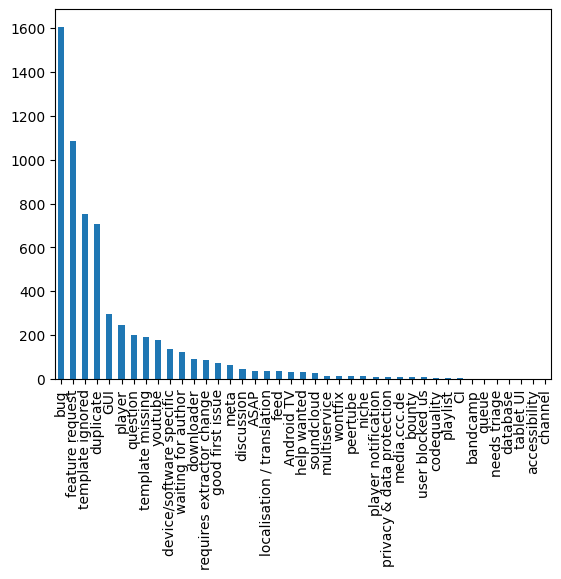

In [18]:
parsed_labels = [literal_eval(label_list) for idx, label_list in df_issues["labels"].items()] #parse labels
flattened_labels = [Label(**item) for item in itertools.chain.from_iterable(parsed_labels)] # flatten and convert to Label
labels_count = pd.Series(item.name for item in flattened_labels).value_counts()
labels_count.plot(kind="bar",)

In [19]:
def remove_outliers(dataset, attribute, factor):
    if factor == 0:
        return dataset
    copy = dataset.copy()
    return copy[numpy.abs(copy[attribute] - copy[attribute].mean()) <= (factor * copy[attribute].std())]

In [20]:
df_issues = remove_outliers(df_issues, "time_to_complete", 1)
# for tag in TAGS:
    # mean, std = df_label_means.loc[df_label_means["label"] == tag.name]
    # print(mean)
    # print(std)
df_issues.shape

(4902, 31)

In [21]:
df_label_means = pd.DataFrame()

for tag in TAGS:
    mean = df_issues.loc[df_issues["labels"].str.contains(tag.node_id)]["time_to_complete"].mean()
    std = df_issues.loc[df_issues["labels"].str.contains(tag.node_id)]["time_to_complete"].std()
    min = df_issues.loc[df_issues["labels"].str.contains(tag.node_id)]["time_to_complete"].min()
    max = df_issues.loc[df_issues["labels"].str.contains(tag.node_id)]["time_to_complete"].max()
    df_label_means = pd.concat([df_label_means, pd.DataFrame.from_records([{"label": tag.name, "time_to_complete_avg": mean, "time_to_complete_std": std, "time_to_complete_min": min, "time_to_complete_max": max}])], ignore_index=True)

In [22]:
df_label_means

,label,time_to_complete_avg,time_to_complete_std,time_to_complete_min,time_to_complete_max
0,player,2481.354516,2670.529357,0.251389,8505.666944
1,meta,1925.707649,2672.437128,0.069167,8345.679722
2,duplicate,118.803215,770.588238,0.011111,8469.069167
3,template ignored,101.881987,495.730406,0.011111,6590.084722
4,user blocked us,3079.124960,2465.826269,72.494722,6012.413333
5,device/software specific,2460.819195,2734.486106,0.254444,8666.894722
6,codequality,402.811898,554.669593,1.661389,1487.716389
7,good first issue,2046.244319,2172.033032,9.772222,8158.167500
8,soundcloud,1008.577253,1458.780840,0.841389,5399.298611
9,privacy & data protection,1241.024931,2306.442499,5.349722,6688.488333


# Explorações do Dataset

In [23]:
def filter_by_tags(dataset, attribute, tags):
    return dataset[dataset[attribute].isin(tags)]

def fetch_comparison_data(dataset, tag, exclude):
    if (exclude):
        return dataset.loc[~dataset["labels"].str.contains(tag)]
    else:
        return dataset.loc[dataset["labels"].str.contains(tag)]

def plot_data_bar(title, labels, dataset, color, width = .15):
    fig, ax = plt.subplots()
    ax.ticklabel_format(style="plain")
    x = numpy.arange(len(labels))

    rectsMin = ax.bar(x - width*3/2, dataset.time_to_complete_min, width, label='Min')
    rectsMax = ax.bar(x - width/2, dataset.time_to_complete_max, width, label='Max')
    rectsAvg = ax.bar(x + width/2, dataset.time_to_complete_avg, width, label='Average')
    rectsStd = ax.bar(x + width*3/2, dataset.time_to_complete_std, width, label='Standard Deviation')
    
    ax.set_ylabel("Time (in hours)")
    ax.set_xticks(x, labels)
    ax.legend()

    fig.tight_layout()

def plot_data_boxplot(title, data):
    fig1, ax1 = plt.subplots()
    ax1.ticklabel_format(style="plain")
    ax1.set_title(title)
    ax1.boxplot(data)

    fig1.tight_layout()

def compare_tag(tag):
    yes_dataset = fetch_comparison_data(df_issues, tag, False)
    no_dataset = fetch_comparison_data(df_issues, tag, True)

    print_test_result(run_mw_test(yes_dataset, no_dataset, 'time_to_complete', label=tag))

def plot_data_barh(title, labels, dataset, color, width = .15):
    fig, ax = plt.subplots()
    ax.ticklabel_format(style="plain")
    y = numpy.arange(len(labels))

    rectsMin = ax.barh(y - width*3/2, dataset.time_to_complete_min, width, label='Min')
    rectsMax = ax.barh(y - width/2, dataset.time_to_complete_max, width, label='Max')
    rectsAvg = ax.barh(y + width/2, dataset.time_to_complete_avg, width, label='Average')
    rectsStd = ax.barh(y + width*3/2, dataset.time_to_complete_std, width, label='Standard Deviation')
    
    ax.set_xlabel("Time (in hours)")
    ax.set_yticks(y, labels)
    ax.legend()

    fig.set_figheight(20)

## RQ 01) Qual é o tempo médio de resolução de issues?

In [24]:
def average_issue_resolution_time():
    base_means_data = df_label_means.loc[~df_label_means.label.isin(misleading_tags)]
    base_means_data_extra = base_means_data.sort_values(by="time_to_complete_avg")
    plot_data_barh("Average time to complete issues (in hours)", base_means_data_extra.label, base_means_data_extra, tag_colors)

    for tag in df_tags.name:
        print(tag)
        compare_tag(tag)
    return

player
Mann-Whitney test result: the H0 was rejected with statistic 611266.0 and p-value 7.339286402332995e-36. Then the alternative hypothesis player_time_to_complete > NON_player_time_to_complete was acepted with statistic 611266.0 and p-value 3.669643201166497e-36, with Cohen’s d effect size = 0.9325141563083311 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
meta
Mann-Whitney test result: the H0 was rejected with statistic 147630.0 and p-value 2.992094482293235e-06. Then the alternative hypothesis meta_time_to_complete > NON_meta_time_to_complete was acepted with statistic 147630.0 and p-value 1.4960472411466175e-06, with Cohen’s d effect size = 0.6107648002075292 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
device/software specific
Mann-Whitney test result: the H0 was rejected with statistic 357136.0 and p-value 2.419450143661038e-19. Then the alternative hypothesis device/software specific_time_to_complete > NON_device/software specific_time_to_complete was a

/home/davit/UFC/mestrado/msr/msr2022/venv/lib/python3.10/site-packages/pingouin/effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
/home/davit/UFC/mestrado/msr/msr2022/venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mann-Whitney test result: the H0 was rejected with statistic 111651.0 and p-value 6.002065088697422e-07. Then the alternative hypothesis feed_time_to_complete > NON_feed_time_to_complete was acepted with statistic 111651.0 and p-value 3.001032544348711e-07, with Cohen’s d effect size = 0.9611825392810366 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
downloader
Mann-Whitney test result: the H0 was rejected with statistic 210766.5 and p-value 1.0040333530311678e-12. Then the alternative hypothesis downloader_time_to_complete > NON_downloader_time_to_complete was acepted with statistic 210766.5 and p-value 5.020166765155839e-13, with Cohen’s d effect size = 0.8678366466022116 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
Android TV
Mann-Whitney test result: the H0 was rejected with statistic 80940.0 and p-value 3.858062554808325e-05. Then the alternative hypothesis Android TV_time_to_complete > NON_Android TV_time_to_complete was acepted with statistic 80940.0 and p-

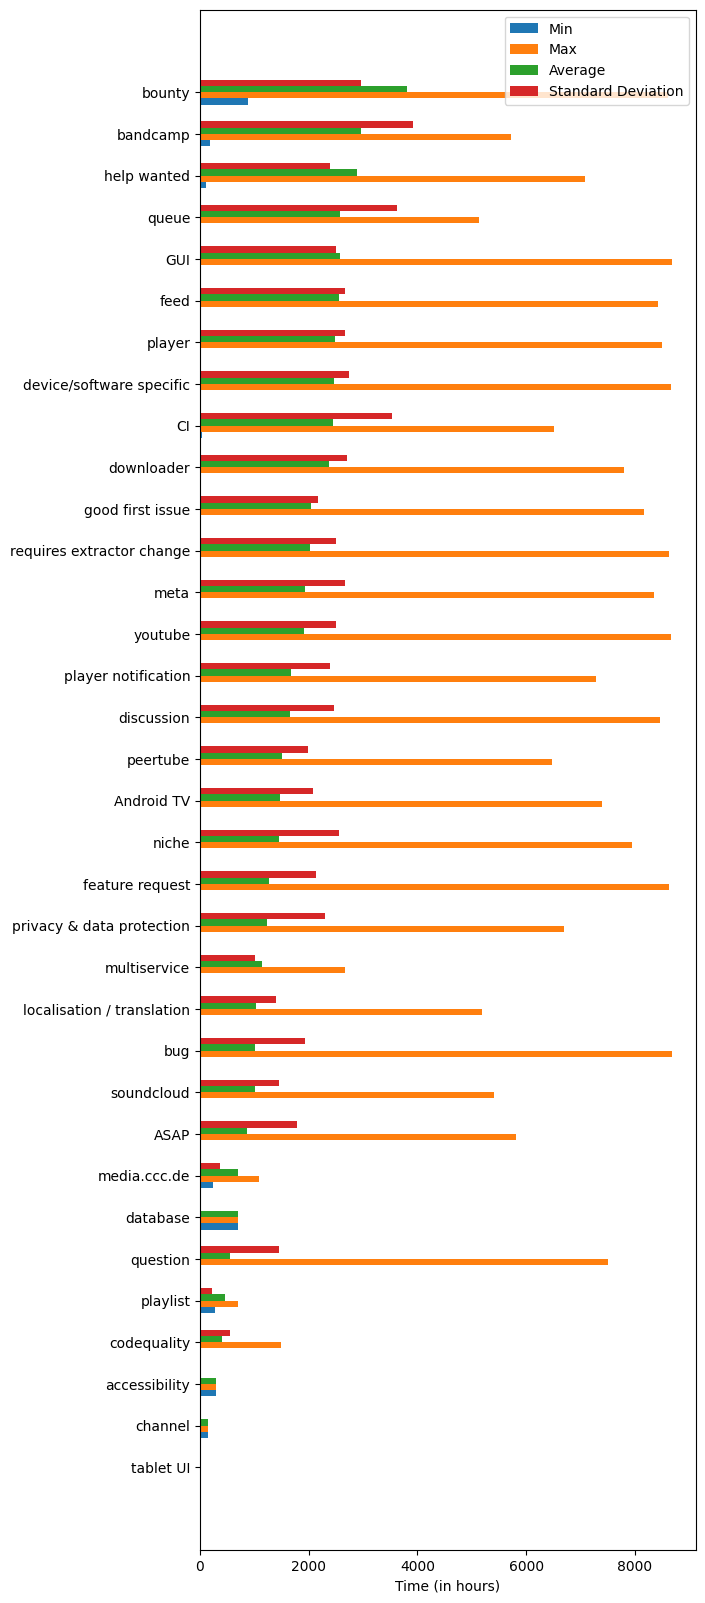

In [25]:
average_issue_resolution_time()

## RQ 02) Existe alguma diferença entre o tempo de resolução de issues entre os serviços suportados pelo NewPipe?

In [26]:
def run_difference_between_issue_resolution():
    service_tags = ['multiservice', 'bandcamp', 'youtube', 'media.ccc.de', 'soundcloud', 'peertube']
    service_issue_time = filter_by_tags(df_label_means, 'label', service_tags)
    service_issue_time = service_issue_time.sort_values(by="time_to_complete_avg",ascending=True)

    plot_data_bar("Average time to complete issues (in hours)", service_issue_time.label, service_issue_time, tag_colors)

    for service in service_tags:
        compare_tag(service)

    print(service_issue_time.shape)
    print(service_issue_time.columns)

Mann-Whitney test result: the hypothesis multiservice_time_to_complete == NON_multiservice_time_to_complete is acepted with statistic 18075.0 and p-value 0.06520404232971905, with Cohen’s d effect size = 0.17450292687798244 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
Mann-Whitney test result: the hypothesis bandcamp_time_to_complete == NON_bandcamp_time_to_complete is acepted with statistic 8038.0 and p-value 0.11689434630100076, with Cohen’s d effect size = 1.1735537784505108 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
Mann-Whitney test result: the H0 was rejected with statistic 581161.0 and p-value 9.242409256264948e-26. Then the alternative hypothesis youtube_time_to_complete > NON_youtube_time_to_complete was acepted with statistic 581161.0 and p-value 4.621204628132474e-26, with Cohen’s d effect size = 0.6201288403221122 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
Mann-Whitney test result: the H0 was rejected with statistic 26557.0 and p-valu

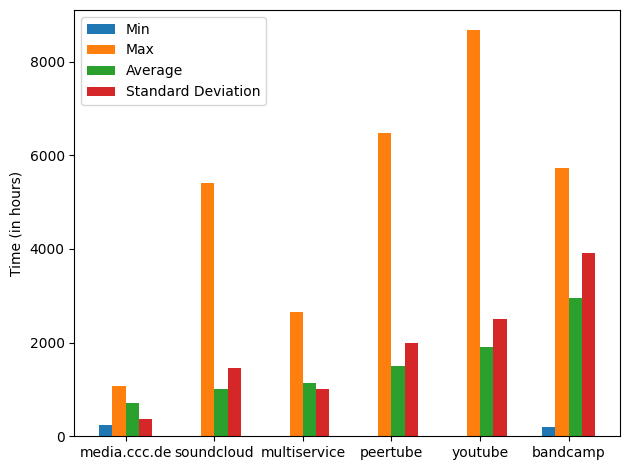

In [27]:
run_difference_between_issue_resolution()

## Box Plots de Distribuição para _Time to Complete_

In [59]:
def format_func(x, pos):
    DAYS_IN_HOURS = 3600 * 24
    days = int(x//DAYS_IN_HOURS)
    hours = int((x%DAYS_IN_HOURS)//3600)
    minutes = int((x%3600)//60)
    seconds = int(x%60)
    sb = ""
    if days > 0:
        sb += f"{days}d "
    sb += f"{hours}:{minutes}:{seconds}"
    return sb
    return "{:d}:{:02d}".format(hours, minutes)
    # return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds)

In [28]:
def show_completion_time_distribution_evolved():
    base_data = df_issues.loc[~df_issues.labels.isin(misleading_tags)]
    base_data.boxplot(by="labels")

/tmp/ipykernel_138010/1097323119.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([name for name, _ in boxplot_data], rotation=30)


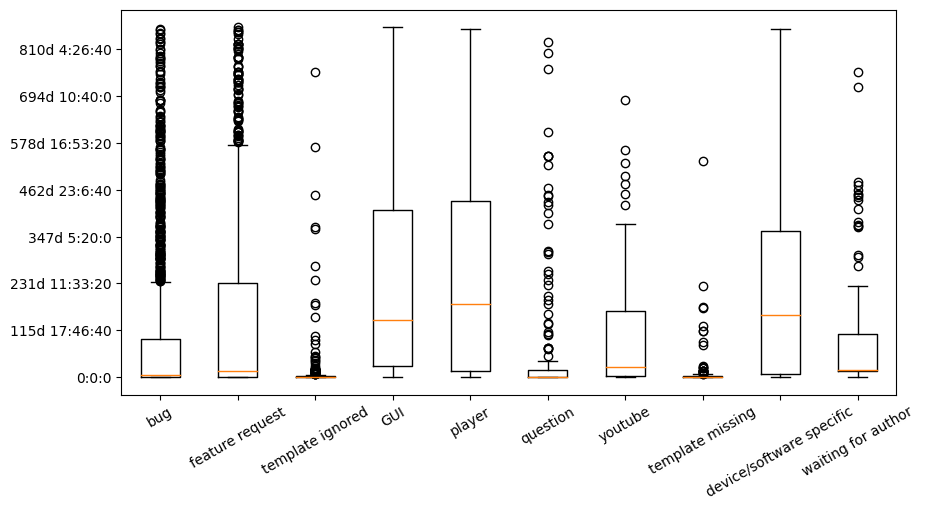

In [74]:
#show_completion_time_distribution_evolved()
def make_boxplot():
    from dataset_loader import load_dataset
    base_data = load_dataset()
    base_data = base_data.loc[~base_data.labels.isin(misleading_tags)]
    boxplot_data = []
    sorted_tags = sorted(TAGS, key=lambda x: x.name)
    for tag in sorted_tags:
        boxplot_data += [(tag.name, [row["time_to_complete"] for _, row in base_data.loc[base_data["labels"].str.contains(tag.node_id)].iterrows()])]
    # sort boxplot data
    boxplot_data = sorted(boxplot_data, key=lambda tup: len(tup[1]), reverse=True)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)

    formatter = FuncFormatter(format_func)
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xticklabels([name for name, _ in boxplot_data], rotation=30)
    ax.boxplot([series for _, series in boxplot_data][:10])
make_boxplot()

In [2]:
def show_completion_time_distribution():
    base_data = df_issues.loc[~df_issues.labels.isin(misleading_tags)]
    for tag in df_tags.name:
        plot_data_boxplot("Time to Complete "+tag+" (in hours)", fetch_comparison_data(base_data, tag, False).time_to_complete)

In [3]:
show_completion_time_distribution()

NameError: name 'df_issues' is not defined